# Part C: Using a DNN to Estimate Area Of Future Fires


In [53]:
import pandas as pd

bushfires_df = pd.read_csv("../data.csv", index_col=0)
bushfires_df['acq_date'] = pd.to_datetime(bushfires_df['acq_date'])

bushfires_df

,acq_date,fires,frp,scan,brightness,max_t_syd,max_t_bne
0.0,2000-11-01,104.0,17572.6,195.4,357.982692,22.8,27.0
1.0,2000-11-02,211.0,45603.4,307.3,351.112322,22.3,24.0
2.0,2000-11-03,181.0,27439.3,325.8,353.117680,23.8,26.0
3.0,2000-11-04,239.0,29887.1,299.7,361.599163,23.0,28.0
4.0,2000-11-05,43.0,7193.7,92.0,347.181395,21.4,28.0
...,...,...,...,...,...,...,...
6919.0,2019-10-12,211.0,36282.4,312.8,361.617062,20.4,21.3
6920.0,2019-10-13,128.0,23654.4,225.6,357.284375,19.2,25.3
6921.0,2019-10-14,230.0,49021.2,346.0,361.449565,21.9,25.9
6922.0,2019-10-15,137.0,23865.6,232.1,357.659854,24.0,27.2


In [54]:
# Feature engineering to introduce seasonality concepts and trends.
import numpy as np

bushfires_df["time_sin"] = np.sin((bushfires_df['acq_date'].dt.day_of_year / 365) * 2 * np.pi)
bushfires_df["time_cos"] = np.cos((bushfires_df['acq_date'].dt.day_of_year / 365) * 2 * np.pi)
bushfires_df["year"] = bushfires_df['acq_date'].dt.year

In [55]:
df = pd.DataFrame()

df['acq_date'] = bushfires_df['acq_date']
df['scan'] = bushfires_df['scan']
df['max_t_syd'] = bushfires_df['max_t_syd']
df['max_t_bne'] = bushfires_df['max_t_bne']
df['time_sin'] = bushfires_df['time_sin']
df['time_cos'] = bushfires_df['time_cos']
df['year'] = bushfires_df['year'] - 2000 # we'll count the years since approx when the data starts.

df = df.dropna()

In [56]:
# Preview what sort of data is in here.
df = df.sort_values(["scan"])

df

,acq_date,scan,max_t_syd,max_t_bne,time_sin,time_cos,year
3534.0,2010-07-06,1.0,17.2,22.5,-0.077386,-0.997001,10
2675.0,2008-02-28,1.0,21.4,29.5,0.849817,0.527078,8
5569.0,2016-01-31,1.0,31.1,34.0,0.508671,0.860961,16
5575.0,2016-02-06,1.0,27.0,29.9,0.594727,0.803928,16
1191.0,2004-02-05,1.0,26.4,27.9,0.580800,0.814046,4
...,...,...,...,...,...,...,...
4371.0,2012-10-20,3719.3,33.8,30.2,-0.939856,0.341571,12
4374.0,2012-10-23,4687.7,19.5,24.8,-0.920971,0.389630,12
730.0,2002-11-01,4722.2,24.5,30.0,-0.858764,0.512371,2
4373.0,2012-10-22,5576.4,18.7,33.2,-0.927542,0.373720,12


In [57]:
# drop acq_date - it isn't required for the model.
df = df.drop(columns=['acq_date'])
df = df.sort_index()

df

,scan,max_t_syd,max_t_bne,time_sin,time_cos,year
0.0,195.4,22.8,27.0,-0.849817,0.527078,0
1.0,307.3,22.3,24.0,-0.840618,0.541628,0
2.0,325.8,23.8,26.0,-0.831171,0.556017,0
3.0,299.7,23.0,28.0,-0.821477,0.570242,0
4.0,92.0,21.4,28.0,-0.811539,0.584298,0
...,...,...,...,...,...,...
6919.0,312.8,20.4,21.3,-0.981306,0.192452,19
6920.0,225.6,19.2,25.3,-0.977848,0.209315,19
6921.0,346.0,21.9,25.9,-0.974100,0.226116,19
6922.0,232.1,24.0,27.2,-0.970064,0.242850,19


In [58]:
# Split into train/test

train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)

train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('scan')
test_labels = test_features.pop('scan')

In [59]:
import tensorflow as tf

# Disable GPU. GPU makes this particular model slower.
tf.config.set_visible_devices([], 'GPU')

In [60]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

In [61]:
# Utility function for the model
def build_and_compile_model():
    model = tf.keras.Sequential([
        normalizer,
        tf.keras.layers.Dense(16, activation='relu'), # Input layer
        tf.keras.layers.Dense(1024, activation='relu'), # Hidden layer
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dense(1) # Output layer
    ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam())
    return model

In [62]:
model = build_and_compile_model()

history = model.fit(
    train_features,
    train_labels,
    validation_data=(test_features, test_labels),
    verbose=1, epochs=1000)

Epoch 1/1000
171/171 [==============================] - 1s 3ms/step - loss: 150.7545 - val_loss: 135.0653
Epoch 2/1000
171/171 [==============================] - 1s 3ms/step - loss: 136.9357 - val_loss: 133.5051
Epoch 3/1000
171/171 [==============================] - 1s 3ms/step - loss: 135.5785 - val_loss: 129.1263
Epoch 4/1000
171/171 [==============================] - 1s 3ms/step - loss: 135.1280 - val_loss: 130.4711
Epoch 5/1000
171/171 [==============================] - 1s 3ms/step - loss: 133.9855 - val_loss: 132.3040
Epoch 6/1000
171/171 [==============================] - 1s 3ms/step - loss: 134.0754 - val_loss: 131.0786
Epoch 7/1000
171/171 [==============================] - 1s 3ms/step - loss: 133.1818 - val_loss: 127.5256
Epoch 8/1000
171/171 [==============================] - 1s 3ms/step - loss: 132.9951 - val_loss: 128.7863
Epoch 9/1000
171/171 [==============================] - 1s 3ms/step - loss: 132.9208 - val_loss: 131.6580
Epoch 10/1000
171/171 [=======================

In [63]:
pd.DataFrame(history.history)

,loss,val_loss
0,150.754456,135.065292
1,136.935730,133.505112
2,135.578522,129.126297
3,135.128021,130.471146
4,133.985458,132.304031
...,...,...
995,34.584209,112.943710
996,34.813457,114.858917
997,34.908932,113.589729
998,35.212231,115.007690


In [64]:
# Utility function for plotting loss
import matplotlib.pyplot as plt

def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

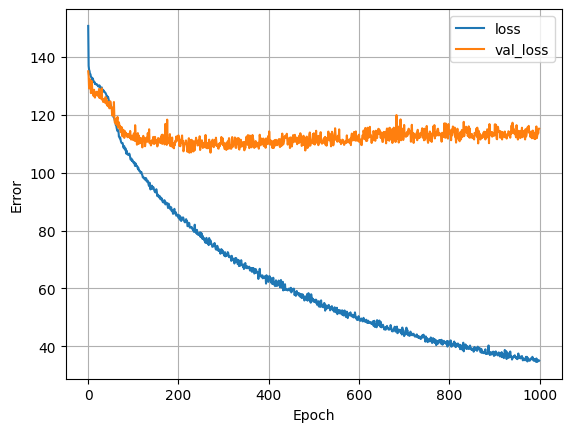

In [65]:
plot_loss(history)

In [66]:
# Save history for record keeping purposes
import time
timestr = time.strftime("%Y%m%d-%H%M%S")

pd.DataFrame(history.history).to_csv("./history/" + timestr + ".csv")

43/43 [==============================] - 0s 1ms/step


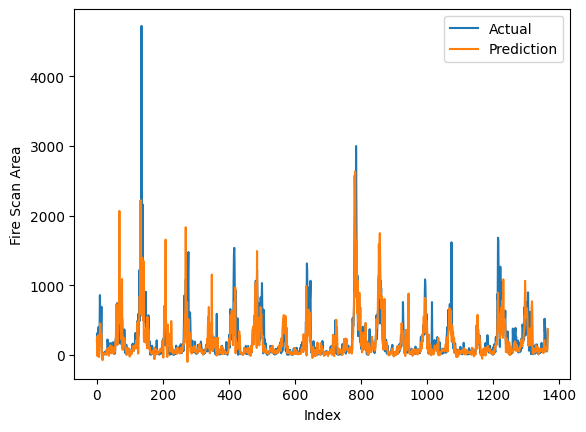

In [67]:
plt.plot(test_labels.reset_index()['scan'], label="Actual")
plt.plot(model.predict(test_features), label="Prediction")
plt.xlabel("Index")
plt.ylabel("Fire Scan Area")
plt.legend()

In [68]:
# testing with some crazy data
new_data = {
    "max_t_syd": [34.023],
    "max_t_bne": [35.253],
    "time_sin": [0.017213],
    "time_cos": [0.999852],
    "year": [52.0]
}

new_df = pd.DataFrame(data=new_data)

model.predict(new_df)

1/1 [==============================] - 0s 10ms/step


array([[4399.105]], dtype=float32)

In [69]:
model.save("../model/model.keras")